In [1]:
import numpy as np
from scipy import linalg, signal
import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True)
plt.rcParams.update({
    'font.family':'Times New Roman',
    # 'text.usetex': True
})

# Problem 2

## 自相关矩阵及特征值的期望

In [2]:
from sympy.abc import a
from sympy.matrices import Matrix
sigma2_v = 0.3
R = Matrix([[1/(1-a**2), -a/(1-a**2)], [-a/(1-a**2), 1/(1-a**2)]])*sigma2_v
R = np.asarray(R.subs(a, 0.85), dtype=float)
p = np.array([-0.85, 0.85**2])/(1-0.85**2)* sigma2_v
sigma_d2 = sigma2_v/(1-0.85**2)
print('Correlation Matrix: ', R)
print('Wiener solution: ',linalg.inv(R)@p)
D, _ = linalg.eig(R)
D = abs(D)
print('lambda max: %.2f' % max(D))

Correlation Matrix:  [[ 1.08108 -0.91892]
 [-0.91892  1.08108]]
Wiener solution:  [-0.85 -0.  ]
lambda max: 2.00


## 预测器一阶 单次

In [3]:
from LMS_algorithm import LMS
a = np.asarray([1, 0.85])
N = 2
mu = 1/abs(sum(D) + 2*max(D))/5
K = 300  # number of iterations
rng = np.random.default_rng()
print('the mu value: %.3f' % mu)

the mu value: 0.032


In [4]:
u = np.sqrt(sigma2_v) * rng.standard_normal(K)
d = signal.lfilter([1], a, u)
x = signal.lfilter([0, 1], [1], d)

ex2 = LMS(N-1, signal_complex=False)
wk, ek = ex2.lms(d, x, **{'fir_order': N - 1, 'init_coefficients': np.array([2, -2]), 'step': mu})

wk_avg = wk[:K]
mse_avg = abs(ek[:K]) ** 2

In [5]:
def plot_learning_curve(K):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    e2db_avg = 10 * np.log10(np.where(mse_avg == 0, float('inf'), mse_avg))
    ax1.plot(e2db_avg)
    ax2.plot(np.real(wk_avg))
    ax2.grid(color='lightgrey', linestyle='-', linewidth=1)
    plt.tight_layout()
    ax1.set_title('Learning Curve for MSE')
    ax1.set_xlabel('Number of iterations, k')
    ax1.set_ylabel('MSE [dB]')
    ax1.set_xlim(0, K)
    ax2.set_xlim(0, K)
    plt.show()

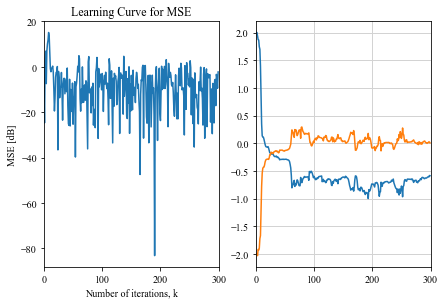

In [6]:
plot_learning_curve(K)

In [7]:
print('the mean value for convergence %.2f ' % np.mean(wk_avg[-5:], axis = 0)[0])

the mean value for convergence -0.60 


## 收敛曲线

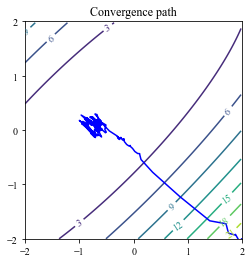

In [8]:
def plot_convergence_path():
    delta = 0.025
    x = np.arange(-2.0, 2.0, delta)
    y = np.arange(-2.0, 2.0, delta)
    X, Y = np.meshgrid(x, y)
    Z = sigma_d2 - 2* (X*p[0] + Y*p[1]) + (X**2*R[0][0] + Y**2*R[1][1] + 2*X*Y*R[1,0])

    fig, ax = plt.subplots()
    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=True, fontsize=10)
    bound = [-1,1,-1,1]
    bound = [b*2 for b in bound]
    ax.axis(bound)
    ax.set_aspect('equal')
    ax.set_yticks(range(-2,3))
    ax.set_title('Convergence path')
    wx = [w[0] for w in wk_avg]
    wy = [w[1] for w in wk_avg]
    plt.plot(wx,wy,'b-')
    plt.show()
plot_convergence_path()

## 预测器 100次平均

In [9]:
# 一阶预测器 100 次平均
mse = []
wk_rec = []
for j in range(100):
    ex2 = LMS(N - 1, signal_complex=False)
    u = np.sqrt(sigma2_v) * rng.standard_normal(K)
    d = signal.lfilter([1], a, u)
    x = signal.lfilter([0, 1], [1], d)

    wk, ek = ex2.lms(d, x, **{'fir_order': N - 1, 'init_coefficients': np.array([2, -2]), 'step': mu})

    mse.append(abs(ek) ** 2)
    wk_rec.append(wk)

wk_avg = np.mean(wk_rec, axis=0)[:K]
mse_avg = np.mean(mse, axis=0)[:K]

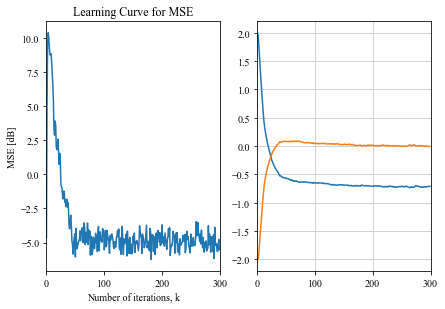

experiment Misadjustment: 0.0863
theory Misadjustment: 0.0694
another number of iteration @coefficient: 435 
another number of iteration @power: 70 


In [10]:
plot_learning_curve(K)
xi = np.mean(mse_avg[-50:])/sigma2_v-1  # M experimental
print('experiment Misadjustment: %.4f' % xi)
xi0 = mu*N/(1-mu*N)  # M theoretical
print('theory Misadjustment: %.4f' % xi0)

# From the view of coefficient
print('another number of iteration @coefficient: %d ' % ( (-2)/np.log10(1-2*mu*min(D)) ) )

# From the view of power
mse_max = max(mse_avg[:N+1])
print('another number of iteration @power: %d ' % np.mean( (np.log10(sigma2_v) - np.log10(mse_max/2) )/np.log10(1-4*mu*(D))+N ))

In [11]:
print('the mean value for convergence %.2f ' % np.mean(wk_avg[-5:], axis = 0)[0])

the mean value for convergence -0.71 


## 最佳一步线性预测器

In [12]:
N = 1
K = 3000
mse = []
wk_rec = []
for j in range(100):
    ex2 = LMS(N-1, signal_complex=False)
    u = np.sqrt(sigma2_v) * rng.standard_normal(K)
    d = signal.lfilter([1], a, u)
    x = signal.lfilter([0, 1], [1], d)

    wk, ek = ex2.lms(d, x, **{'fir_order': N - 1, 'init_coefficients': np.ones(N), 'step': mu})

    mse.append(abs(ek) ** 2)
    wk_rec.append(wk)

wk_avg = np.mean(wk_rec, axis=0)[:K]
mse_avg = np.mean(mse, axis=0)[:K]

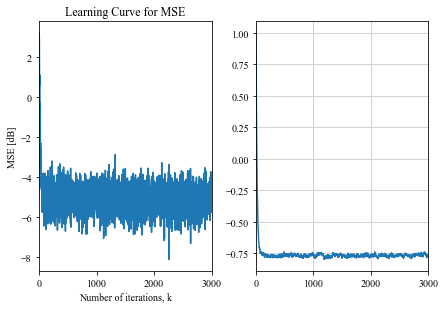

the mean value for convergence -0.76 


In [13]:
plot_learning_curve(K)
print('the mean value for convergence %.2f ' % np.mean(wk_avg[-5:], axis = 0)[0])

- LMS 算法收敛的系数收敛到 0 极慢。

# Problem 5

In [14]:
mse = []
wk_rec = []
K = 300
N = 2
for j in range(100):
    ex5 = LMS(N - 1, signal_complex=False)
    u = np.sqrt(sigma2_v) * rng.standard_normal(K)
    d = signal.lfilter([1], a, u)
    x = signal.lfilter([0, 1], [1], d)

    wk, ek = ex5.mlms(d, x, gamma=0.95, **{'fir_order': N - 1, 'init_coefficients': np.array([2, -2]), 'step': mu})

    mse.append(abs(ek) ** 2)
    wk_rec.append(wk)

wk_avg = np.mean(wk_rec, axis=0)[:K]
mse_avg = np.mean(mse, axis=0)[:K]

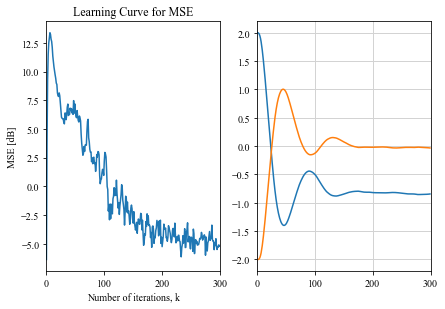

experiment Misadjustment: 0.1668
theory Misadjustment: 0.0694


In [15]:
plot_learning_curve(K)
xi = np.mean(mse_avg[-100:])/sigma2_v-1  # M experimental
print('experiment Misadjustment: %.4f' % xi)
xi0 = mu*N/(1-mu*N)  # M theoretical
print('theory Misadjustment: %.4f' % xi0)

In [16]:
print('the mean value for convergence %.2f ' % np.mean(wk_avg[-5:], axis = 0)[0])

the mean value for convergence -0.85 


## MLMS

- Drawback: The convergence rate may decrease. 
- Advantages: The momentum term keeps the algorithm active even in the regions close to minimum.
- MLMS 使得系数更快收敛到期望，即使在极值附近仍能保持较快的收敛。

# Problem 12

## 自相关的期望及特征值

In [17]:
a = (1, 1.2, 0.81)
pi = np.pi
r = np.sqrt(a[2])
f0 = np.arccos(-a[1]/(2*r))/(2*pi)
sigma = 1
sigma2_v = sigma**2
sigma2_n = 0.04
mu = 1/20
b = [1, 0.9, 0.1, 0.2]

In [18]:
phi = np.arctan((1-r**2)/(1+r**2)/np.tan(2*pi*f0))

In [19]:
rxx = [sigma2_v*(1+r**2)/(1-r**2)*np.sqrt(1+(1-r**2)/(1+r**2)**2/np.tan(2*pi*f0))*r**k*np.cos(2*pi*f0*k-phi)/(1-2*r**2*np.cos(4*pi*f0)+r**4) for k in range(5)]

In [20]:
R = np.asarray(linalg.toeplitz(rxx[:4]))
abs(R @ np.array([1.2, 0.81, 0, 0]) + rxx[1:5]) < 1e-4  # check inv-system

array([ True,  True,  True,  True])

In [21]:
D,V = linalg.eig(R)
D = abs(D)
print(D)
N = 4
mu = 1/abs(sum(D) + 2*max(D))/5
K = 2000  # number of iterations
rng = np.random.default_rng()
print('the mu value: %.3f' % mu)

[0.82941 0.176   9.33716 9.77687]
the mu value: 0.005


## 学习曲线 20次

In [22]:
mse = []
wk_rec = []
for j in range(20):
    ex12 = LMS(N - 1, signal_complex=False)
    u = np.sqrt(sigma2_v) * rng.standard_normal(K)
    x = signal.lfilter([1], a, u)
    d = signal.lfilter(b, [1], x) + np.sqrt(sigma2_n) * rng.standard_normal(K)

    wk, ek = ex12.lms(d, x, **{'fir_order': N - 1, 'init_coefficients': np.ones(N), 'step': mu})

    mse.append(abs(ek) ** 2)
    wk_rec.append(wk)

wk_avg = np.mean(wk_rec, axis=0)[:K]
mse_avg = np.mean(mse, axis=0)[:K]

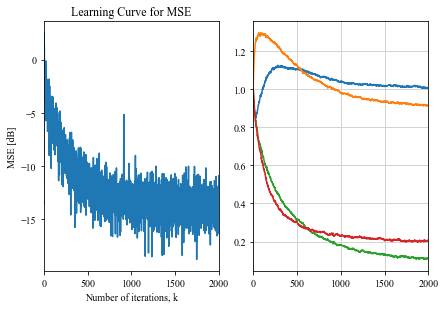

In [23]:
plot_learning_curve(K)

## Eq(3.46) 的学习曲线

In [24]:
v0 = V.T @ (wk_avg[0]- np.asarray(b))[np.newaxis].T @ (wk_avg[0]- np.asarray(b))[np.newaxis] @ V
v0 = np.diag(v0)
# print(v0)

epislon = []
v = v0
for i in range(K):
    v_new = np.array(())
    for v_i,lambda_i in zip(v, D):
        v_i_new = (1 - 4*mu*lambda_i + 8*mu**2*lambda_i**2)*v_i + 4*mu**2*lambda_i*D@v + 4*mu**2*sigma2_n*lambda_i
        v_new = np.append(v_new, v_i_new)
    v = v_new
    epislon.append(D @ v + sigma2_n)

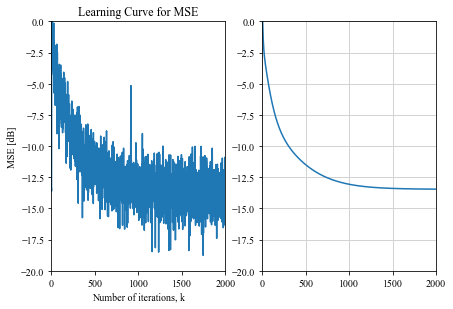

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)
e2db_avg = 10 * np.log10(mse_avg)
ax1.plot(e2db_avg)
e2db_avg = 10 * np.log10(epislon)
ax2.plot(e2db_avg)
ax2.grid(color='lightgrey', linestyle='-', linewidth=1)
plt.tight_layout()
ax1.set_title('Learning Curve for MSE')
ax1.set_xlabel('Number of iterations, k')
ax1.set_ylabel('MSE [dB]')
ax1.set_xlim(0, K)
ax2.set_xlim(0, K)
ax1.set_ylim(-20, 0)
ax2.set_ylim(-20, 0)
plt.show()

## 失调理论值和实验值

In [26]:
xi = np.mean(mse_avg[-500:])/sigma2_n-1  # M experimental
print('experiment Misadjustment: %.4f' % xi)
print('experiment Misadjustment with Eq(3.46): %.4f' % (D @ v /sigma2_n))
xi0 = mu*N/(1-mu*N)  # M theoretical
print('theory Misadjustment: %.4f' % xi0)

experiment Misadjustment: 0.1604
experiment Misadjustment with Eq(3.46): 0.1290
theory Misadjustment: 0.0206


## 期待迭代次数

In [27]:
# From the view of power
mse_max = max(mse_avg[:N+1])
print('another number of iteration @power: %d ' % np.mean( (np.log10(sigma2_n) - np.log10(mse_max/2) )/np.log10(1-4*mu*(D))+N ))

another number of iteration @power: 227 


In [28]:
# 书本上的算法
tau_w = 1/2/mu/D
print('tau_w: ', tau_w)
tau_e = tau_w/2
print('tau_e: ', tau_e)
print('expected number of iteration: ', round(max(tau_e)*np.log(100)))

tau_w:  [119.58191 563.5302   10.62239  10.14466]
tau_e:  [ 59.79096 281.7651    5.31119   5.07233]
expected number of iteration:  1298


# Problem 22

In [29]:
# generate the noise
K = 3000
u_white = np.random.randn(K);
S = 10**(-1.5)*(np.fft.rfftfreq(K*2-1))**(3/2)
# Normalize S
S = S / np.sqrt(np.mean(S**2)) * np.sqrt(2/5*(np.pi/10)**(3/2))
u_shaped = u_white * S
print(np.var(u_shaped))
print(2/5*(np.pi/10)**(3/2))

0.06848347301123597
0.0704343969154842


## 自相关的期望及特征值

In [30]:
b = np.array([-0.001,-0.002,0.002,0.2,0.6,0.76,0.9,0.78,0.67,0.58,0.45,0.3,0.2,0.12,0.06,0,-0.2,-1,-2,-1,0,0.1])
b = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,-2])
a = np.array([1, -0.9])

In [31]:
K = 5000
p = np.zeros(50)
rxx = np.zeros(50)
for j in range(1):
    u_white = np.random.randn(K);
    S = 10**(-1.5)*(np.fft.rfftfreq(K*2-1))**(3/2)
    S = S / np.sqrt(np.mean(S**2)) * np.sqrt(2/5*(np.pi/10)**(3/2))
    u_shaped = u_white * S
    x = np.sign(rng.standard_normal(K))
    x1 = signal.lfilter(b, a, x) + u_shaped
    corr_p = [x @ x1 /K]
    corr_x1 = [x1 @ x1 /K]
    for i in range(1, len(p)):
        d = np.pad(x, (i, 0))[:K]
        corr_p.append(d @ x1 / K)
        corr_x1.append(np.pad(x1, (i, 0))[:K] @ x1 / K)
    p = p + np.asarray(corr_p)
    rxx = rxx + np.asarray(corr_x1)
p = p / 1
rxx = rxx / 1

In [32]:
delay = np.argmax(abs(p))
print(delay)
print(p[np.argmax(abs(p))])
print(p)

18
-1.530969648505294
[ 0.05127  0.0307   0.05096  0.05548  0.05251  0.11652  0.05307  0.05951
  0.072    0.0703   0.06566  0.02919  0.04283  0.0461   0.03213  0.02409
  0.05193  0.50294 -1.53097 -1.41993 -1.25332 -1.12299 -1.01563 -0.92134
 -0.80587 -0.7468  -0.6823  -0.6097  -0.53794 -0.45014 -0.46302 -0.3674
 -0.33353 -0.27504 -0.22085 -0.2168  -0.19859 -0.14407 -0.11332 -0.07219
 -0.05672 -0.04397 -0.01837 -0.00948 -0.04115 -0.05926 -0.06136 -0.02747
 -0.02998 -0.04805]


In [33]:
R = np.asarray(linalg.toeplitz(rxx[:22]))

In [34]:
D,V = linalg.eig(R)
D = abs(D)
print(D)
mu = 1/abs(sum(D) + 2*max(D))/5
print('the mu value: %.6f' % mu)

[131.64892  58.14591  24.39297  12.96129   8.54372   6.22931   4.78631
   3.97006   3.376     2.82509   2.70197   2.60383   2.36196   2.09952
   1.65107   1.68358   1.74055   1.72689   1.84931   1.92081   1.9969
   1.98611]
the mu value: 0.000367


## FIR

In [35]:
K = 3000
mse = []
wk_rec = []
N = 22
for j in range(20):
    ex22 = LMS(N - 1, signal_complex=False)
    u_white = np.random.randn(K);
    S = 10**(-1.5)*(np.fft.rfftfreq(K*2-1))**(3/2)
    S = S / np.sqrt(np.mean(S**2)) * np.sqrt(2/5*(np.pi/10)**(3/2))
    u_shaped = u_white * S
    x = np.sign(rng.standard_normal(K))
    x1 = signal.lfilter(b, a, x) + u_shaped
    d = np.pad(x, (delay, 0))[:K]
    wk, ek = ex22.mlms(d, x1, **{'fir_order': N - 1, 'init_coefficients': np.ones(N), 'step': mu})

    mse.append(abs(ek) ** 2)
    wk_rec.append(wk)

wk_avg = np.mean(wk_rec, axis=0)[:K]
mse_avg = np.mean(mse, axis=0)[:K]

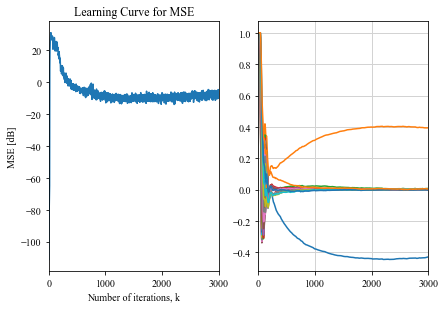

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2)
e2db_avg = 10 * np.log10(np.where(mse_avg == 0, float('inf'), mse_avg))
ax1.plot(e2db_avg)
ax2.plot(np.real(wk_avg))
ax2.grid(color='lightgrey', linestyle='-', linewidth=1)
plt.tight_layout()
ax1.set_title('Learning Curve for MSE')
ax1.set_xlabel('Number of iterations, k')
ax1.set_ylabel('MSE [dB]')
ax1.set_xlim(0, K)
ax2.set_xlim(0, K)
plt.show()

In [37]:
print(wk_avg[-1])

[-0.42907  0.39401  0.00695  0.00048 -0.00005  0.00257 -0.00088 -0.00124
  0.00236 -0.0022  -0.00037  0.00061 -0.00022  0.00425 -0.00306  0.00023
  0.00014 -0.00141  0.00267  0.00029 -0.00269  0.00329]


# Problem 23

## Training

In [38]:
def DFE_train(desired, fed, *, step, fir_order, init_coefficients):
    error_vector, output_vector = np.zeros((2, len(desired)))

    N_feedback = 5
    N_forward = fir_order + 1 - N_feedback

    coefficient_vector_forward = np.zeros((len(desired) + 1, N_forward))
    coefficient_vector_feedback = np.zeros((len(desired) + 1, N_feedback))
    coefficient_vector_forward[0], coefficient_vector_feedback[0] = np.split(init_coefficients, [N_forward])
    
    prefixed_input = np.concatenate((np.zeros(N_forward-1), fed))
    prefixed_desired = np.concatenate((np.zeros(N_feedback), desired))

    for i in range(len(desired)):
        regress_forward = (prefixed_input[i:i + N_forward])[::-1]
        regress_feedback = (prefixed_desired[i:i + N_feedback])[::-1]
        output_forward = regress_forward.conj() @ coefficient_vector_forward[i]
        output_feedback = regress_feedback.conj() @ coefficient_vector_feedback[i]
        # output_feedback = 0
        # output_final  = np.sign(output_forward - output_feedback)
        output_final = desired[i]
        e = output_final - (output_forward - output_feedback)
        coefficient_vector_forward[i + 1] = (coefficient_vector_forward[i] + 2 * step * e.conj() * regress_forward)
        coefficient_vector_feedback[i + 1] = (coefficient_vector_feedback[i] - 2 * step * e.conj() * regress_feedback)

        output_vector[i] = output_final
        error_vector[i] = e

    return coefficient_vector_forward, coefficient_vector_feedback, error_vector, output_vector

In [39]:
N = 50
mse = []
wk_rec_forward = []
wk_rec_feedback = []
for j in range(10):
    u_white = np.random.randn(K);
    S = 10**(-1.5)*(np.fft.rfftfreq(K*2-1))**(3/2)
    S = S / np.sqrt(np.mean(S**2)) * np.sqrt(2/5*(np.pi/10)**(3/2))
    u_shaped = u_white * S
    x = np.sign(rng.standard_normal(K))
    x1 = signal.lfilter(b, a, x) + u_shaped
    d = np.pad(x, (delay, 0))[:K]
    wk_p1, wk_p2, ek, out = DFE_train(d, x1, **{'fir_order': N - 1, 'init_coefficients': np.ones(N), 'step': mu/2})

    mse.append(abs(ek) ** 2)
    wk_rec_forward.append(wk_p1)
    wk_rec_feedback.append(wk_p2)

wk_avg = np.mean(wk_rec_forward, axis=0)[:K]
mse_avg = np.mean(mse, axis=0)[:K]
wk_avg_feedback = np.mean(wk_rec_feedback, axis=0)[:K]

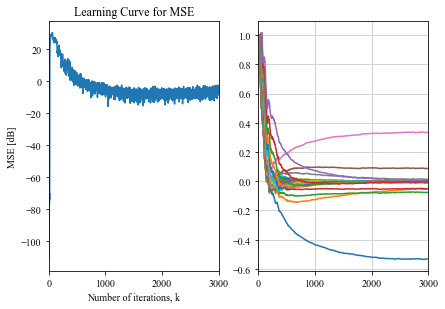

In [40]:
plot_learning_curve(K)

In [41]:
init_coefficients = np.hstack((wk_avg[-1], wk_avg_feedback[-1]))
print(wk_avg[-1])
print(wk_avg_feedback[-1])

[-0.53008 -0.05072 -0.07634 -0.04996 -0.01027  0.08831  0.33298  0.01277
 -0.00077 -0.00288 -0.00296 -0.00215 -0.00288 -0.00317 -0.00286 -0.00136
 -0.00357 -0.00369 -0.00272 -0.0016  -0.00222 -0.00157  0.00093 -0.00204
 -0.0009   0.00115 -0.00029 -0.00077 -0.00147 -0.00193 -0.00431 -0.00317
 -0.00099  0.00096  0.00181  0.00222  0.00097  0.00191 -0.00021  0.00218
  0.00147  0.00091 -0.00096 -0.00454  0.00695]
[0.87209 0.90262 0.90478 0.87812 0.80734]


## Blind

In [42]:
def DFE_blind(fed, *, step, fir_order, init_coefficients):
    error_vector = np.zeros(len(fed))

    N_feedback = 5
    N_forward = fir_order + 1 - N_feedback
    
    coefficient_vector_forward = np.zeros((len(fed) + 1, N_forward))
    coefficient_vector_feedback = np.zeros((len(fed) + 1, N_feedback))
    coefficient_vector_forward[0], coefficient_vector_feedback[0] = np.split(init_coefficients, [N_forward])

    prefixed_input = np.concatenate((np.zeros(N_forward-1), fed))
    prefixed_output = np.zeros(N_feedback + len(fed))

    for i in range(len(fed)):
        regress_forward = (prefixed_input[i:i + N_forward])[::-1]
        regress_feedback = (prefixed_output[i:i + N_feedback])[::-1]
        output_forward = regress_forward.conj() @ coefficient_vector_forward[i]
        output_feedback = regress_feedback.conj() @ coefficient_vector_feedback[i]

        output_final  = np.sign(output_forward - output_feedback)
        prefixed_output[i + N_feedback] = output_final
        e = output_final - (output_forward - output_feedback)
        coefficient_vector_forward[i + 1] = (coefficient_vector_forward[i] + 2 * step * e.conj() * regress_forward)
        coefficient_vector_feedback[i + 1] = (coefficient_vector_feedback[i] - 2 * step * e.conj() * regress_feedback)

        error_vector[i] = e
    output_vector = prefixed_output[N_feedback:]

    return coefficient_vector_forward, coefficient_vector_feedback, error_vector, output_vector

In [43]:
mse = []
wk_rec_forward = []
wk_rec_feedback = []
N = 50
for j in range(1):
    u_white = np.random.randn(K);
    S = 10**(-1.5)*(np.fft.rfftfreq(K*2-1))**(3/2)
    S = S / np.sqrt(np.mean(S**2)) * np.sqrt(2/5*(np.pi/10)**(3/2))
    u_shaped = u_white * S
    x = np.sign(rng.standard_normal(K))
    d = np.pad(x, (delay, 0))[:K]
    x1 = signal.lfilter(b, a, x) + u_shaped
    wk_p1, wk_p2, ek, out = DFE_blind(x1, **{'fir_order': N - 1, 'init_coefficients': init_coefficients, 'step': mu/2})

    mse.append(abs(ek) ** 2)
    wk_rec_forward.append(wk_p1)
    wk_rec_feedback.append(wk_p2)

wk_avg = np.mean(wk_rec_forward, axis=0)[:K]
mse_avg = np.mean(mse, axis=0)[:K]

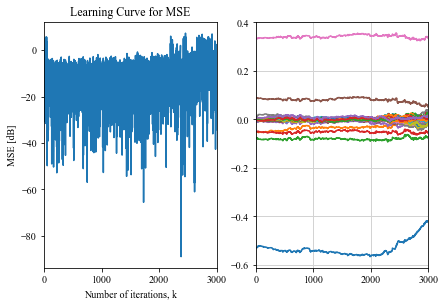

In [44]:
plot_learning_curve(K)

In [45]:
print(wk_avg[-1])
print(wk_avg_feedback[-1])

[-0.41756 -0.02207 -0.0752  -0.05525 -0.02658  0.05233  0.33464  0.03238
 -0.00193  0.00292  0.00426  0.01138  0.00361  0.02605  0.01446  0.01777
  0.0099  -0.00544 -0.01269 -0.01202  0.01239  0.00153  0.02136  0.00638
  0.00571 -0.00588 -0.01195 -0.02287 -0.01985 -0.00444 -0.02237  0.01012
  0.00029 -0.01002 -0.01182 -0.01372 -0.00796 -0.00902 -0.01538  0.00285
  0.01378  0.00442  0.01612  0.00957  0.0141 ]
[0.87209 0.90262 0.90478 0.87812 0.80734]


In [46]:
print( out[ :20] )
print( x[ :20])
print( d[ :20])
print( 'the error rate : %2d%%' % (sum(abs(d - out))/2/K*100) )

[ 0.  1. -1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1. -1. -1.  1.  1.
 -1.  1.]
[-1.  1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1.  1.
  1. -1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 -1.  1.]
the error rate :  4%


## Test ARMMA

In [47]:
def test_arma():
    b = np.array([1, -0.1, 0.2])
    a = np.array([1, -0.9, 0.5])
    u = np.random.randn(10)
    x1 = signal.lfilter(b, a, u)

    prefixed_u = np.pad(u, (len(b)-1, 0))
    prefixed_output = np.zeros(len(a) - 1 + len(u))
    for i in range(len(u)):
        regress_forward = (prefixed_u[i:i + len(b)])[::-1]
        regress_feedback = (prefixed_output[i:i + len(a) - 1])[::-1]
        # print(regress_forward)
        # print(regress_feedback)
        output_forward = regress_forward @ b
        output_feedback = regress_feedback @ a[1:]
        
        output_final  = (output_forward - output_feedback)
        
        # print(output_final.round(3))
        prefixed_output[i + len(a) -1] = output_final
        
    x2 = prefixed_output[len(a)-1:]
    
    return u, x1, x2

for array in test_arma():
    print(array)

[ 0.09832 -0.14992  1.18974 -0.02153 -0.36802 -0.98077 -0.40028  0.53153
  0.48871  2.16961]
[ 0.09832 -0.07126  1.1111   0.86513  0.09515 -1.2952  -1.58907 -0.40715
  0.78359  3.13586]
[ 0.09832 -0.07126  1.1111   0.86513  0.09515 -1.2952  -1.58907 -0.40715
  0.78359  3.13586]
